# Training the model

In [72]:
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))


In [73]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#progress bar
from tqdm import trange
from tqdm import tqdm

In [74]:
torch.set_default_dtype(torch.float32)

In [75]:
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Loading and preparing data

In [76]:
#test_size = 0.2
#train_df, test_df = train_test_split(data, test_size=test_size, random_state=42)




In [77]:

data = pd.read_csv("/kaggle/input/airbnbdata-barcelona/listing_data_lower_dimension.csv")
data = data.select_dtypes(exclude=['object', 'string'])

picture_dir = "/kaggle/input/airbnbdata-barcelona/picture_url_128x128/picture_url_128x128"
host_picture_dir = "/kaggle/input/airbnbdata-barcelona/host_picture_url_128x128/host_picture_url_128x128"

def image_exist(img_id):
    img_id = int(img_id)
    picture_path = os.path.join(picture_dir, f"image_{img_id}.jpg")
    return os.path.isfile(picture_path)

def host_image_exists(img_id):
    img_id = int(img_id)
    host_path = os.path.join(host_picture_dir, f"image_{img_id}.jpg")
    return os.path.isfile(host_path)

data["picture_exists"] = data["id"].apply(image_exist)
data["host_picture_exists"] = data["id"].apply(host_image_exists)

target_clm = "price"
data = data.dropna(subset=[target_clm, "id"])

#Normalization stats from training data
data_mean = data.drop([target_clm, "id"], axis=1).mean().astype(np.float32).values
data_std = data.drop([target_clm, "id"], axis=1).std().replace(0, 1).astype(np.float32).values

#imputer = KNNImputer()
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data)
data = pd.DataFrame(data_imputed, columns=data.columns)  


train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

#scaler = StandardScaler()
#train_scaled = scaler.fit_transform(train_imputed)
#test_scaled = scaler.transform(test_imputed)

#pca = PCA(n_components=100)
#train_pca = pca.fit_transform(train_scaled)
#test_pca = pca.transform(test_scaled)

#print("Train PCA shape:", train_pca.shape)
#print("Test PCA shape:", test_pca.shape)


## Dataset

In [78]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, target_clm, image_dir_host, image_dir_picture, normalize=True, img_mean = None, img_std = None, tab_mean = None, tab_std = None ,transform=None):
        self.data = dataframe
        self.target_clm = target_clm
        self.image_dir_host = image_dir_host
        self.image_dir_picture = image_dir_picture
        
        self.transform = transform if transform else transforms.ToTensor()
        self.normalize = normalize
        self.img_mean = torch.tensor(img_mean).view(3, 1, 1) if img_mean is not None else None
        self.img_std = torch.tensor(img_std).view(3, 1, 1) if img_std is not None else None
        self.tab_mean = torch.tensor(tab_mean, dtype=torch.float32) if tab_mean is not None else None
        self.tab_std = torch.tensor(tab_std, dtype=torch.float32) if tab_std is not None else None

        self.tab_features = dataframe.drop(columns = ["id", self.target_clm]).to_numpy(dtype=np.float32)
        self.targets = dataframe[target_clm].to_numpy()

        self.avg_img = Image.new('RGB', (128, 128), (int(0.485 * 255), int(0.456 * 255), int(0.406 * 255)))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_id = int(row['id'])
        target = self.data[self.target_clm].iloc[idx]

        
        img_path_host = os.path.join(self.image_dir_host, f"image_{img_id}.jpg")
        img_path_picture = os.path.join(self.image_dir_picture, f"image_{img_id}.jpg")

        img_host = None
        img_picture = None

        if not os.path.isfile(img_path_host):  
            #avg_img = Image.new('RGB', (128, 128), (int(0.485 * 255), int(0.456 * 255), int(0.406 * 255)))
            img_host = self.transform(self.avg_img)
        else:
            img_host = Image.open(img_path_host)
            img_host = self.transform(img_host)
            
        if not os.path.isfile(img_path_picture):
            img_picture = self.transform(self.avg_img)

        else:
            img_picture = Image.open(img_path_picture)
            img_picture = self.transform(img_picture)

        

        x_tab = self.tab_features[idx]

        if self.normalize:
            if self.img_mean is not None and self.img_std is not None:
                img_host = (img_host - self.img_mean) / self.img_std
                img_picture = (img_picture - self.img_mean) / self.img_std 
            if self.tab_mean is not None and self.tab_std is not None:
                x_tab = (x_tab - self.tab_mean.numpy()) / self.tab_std.numpy()

        x_tab = torch.tensor(x_tab, dtype=torch.float32)
        y = torch.tensor([target], dtype=torch.float32)
                
        
        return (img_host, img_picture, x_tab), y


        

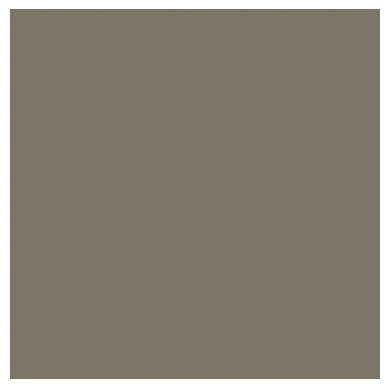

torch.Size([1095])


In [79]:


#typical for normal images
img_mean = [0.485, 0.456, 0.406]
img_std  = [0.229, 0.224, 0.225]

#tab_train_features = train_df.drop(columns=['id', target_clm])

#tab_train_mean = tab_train_features.mean().astype(np.float32).values
#tab_train_std = tab_train_features.std().replace(0, 1).astype(np.float32).values

#tab_test_features = test_df.drop(columns=['id', target_clm])

#tab_test_mean = tab_test_features.mean().astype(np.float32).values
#tab_test_std = tab_test_features.std().replace(0, 1).astype(np.float32).values

transform = transforms.ToTensor()
#data argumentation
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2),
    #transforms.RandomResizedCrop(128),
    transforms.ToTensor()
])

train_dataset_full = ImageDataset(train_df, target_clm, host_picture_dir, picture_dir, normalize = True, img_mean =  img_mean, img_std = img_std, tab_mean = data_mean, tab_std = data_std, transform = transform)
test_dataset = ImageDataset(test_df, target_clm, host_picture_dir, picture_dir, normalize = True, img_mean =  img_mean, img_std = img_std, tab_mean = data_mean, tab_std = data_std ,transform = transform)



def show_tensor_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Clone to avoid modifying original tensor
    tensor = tensor.clone().detach()

    # Unnormalize
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)

    # Clip to [0, 1] range
    tensor = tensor.clamp(0, 1)

    # Convert to [H, W, C] for matplotlib
    np_img = tensor.permute(1, 2, 0).cpu().numpy()

    # Plot
    plt.imshow(np_img)
    plt.axis('off')
    plt.show()

(_,a,b),_ = train_dataset_full.__getitem__(1234)

show_tensor_image(a)

print(b.shape)

In [80]:
#split train/val
torch.manual_seed(0)
val_ratio = 0.1

train_dataset, val_dataset = random_split(train_dataset_full, [1 - val_ratio, val_ratio])

#DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

images, targets = next(iter(train_loader))

print(images[0].shape)
print(images[1].shape)
print()

torch.Size([128, 3, 128, 128])
torch.Size([128, 3, 128, 128])



## Defining the models

In [81]:
class ResNetBlock(nn.Module):
    def __init__(self, channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        identity = x #(for resnet block adding)
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out += identity
        out = self.relu(out)
        return out

In [82]:
#lossly based on resNet 12 https://www.researchgate.net/figure/The-structure-of-ResNet-12_fig1_329954455
class CNNBranch(nn.Module):
    def __init__(self, in_channels=3, num_classes=32):
        super(CNNBranch, self).__init__()


        #added because of strong overfitting
        self.dropout = nn.Dropout(p=0.1)

        #inital conv and pooling
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            self.dropout,
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )

        #ResNet blocks
        self.resnet_blocks = nn.Sequential(
            ResNetBlock(64),
            ResNetBlock(64),
            ResNetBlock(64),
            ResNetBlock(64),
            ResNetBlock(64),
        )
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1,1)) #Output: [B, 64, 1, 1]

        # Fully connected Layer

        self.classifier = nn.Linear(64,32)
    

    
    def forward(self, x):
        x = self.stem(x)
        x = self.resnet_blocks(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

        
    


In [83]:
class PriceCNN(nn.Module):
    def __init__(self):
        super(PriceCNN, self).__init__()
        self.interior_branch = CNNBranch()
        self.host_branch = CNNBranch()

        
    def forward(self, interior_img, host_img):
        f1 = self.interior_branch(interior_img)
        f2 = self.host_branch(host_img)

        combined = torch.cat((f1, f2), dim=1) #cat along channel axis
        return combined.view(combined.size(0), -1) #flatten output
    


In [84]:
class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super(TabularNN, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.mlp(x)

In [85]:
class FullMultimodalModel(nn.Module):
    def __init__(self, tab_input_dim):
        super(FullMultimodalModel, self).__init__()
        self.image_net = PriceCNN()
        self.tab_net = TabularNN(tab_input_dim)

        img_feature_dim = 2 * 32
        tab_feature_dim = 64

        self.dropout = nn.Dropout(p=0.1)

        self.regressor = nn.Sequential(
            nn.Linear(img_feature_dim + tab_feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,1),
        )
    def forward(self, tab_data, interior_img, host_img):
        img_features = self.image_net(interior_img, host_img)
        tab_features = self.tab_net(tab_data)

        combined = torch.cat((img_features, tab_features), dim=1)
        return self.regressor(combined)

In [86]:
print("Any NaN in features? ", np.isnan(train_df.drop(target_clm, axis=1).to_numpy()).any())
print("Any NaN in target? ", np.isnan(train_df[target_clm].to_numpy()).any())

Any NaN in features?  False
Any NaN in target?  False


In [87]:
def validate(dataloader, model, loss_fn, device, master_bar):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            (interior_img, host_img, tab), price = batch
            interior_img, host_img, tab, price = interior_img.to(device), host_img.to(device), tab.to(device),price.to(device)

            #validate
            outputs = model(tab, interior_img, host_img)
            loss = loss_fn(outputs, price)
            val_loss += loss.item()

            master_bar.set_description(f"Epoch {master_bar.n + 1} (Validate)")
            master_bar.set_postfix(loss=f"{loss.item():.3f}")
    
    return val_loss / len(dataloader)

In [88]:
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    model.train()
    train_loss = 0.0
    for batch in dataloader:
        (interior_img, host_img, tab), price = batch
        interior_img = interior_img.to(device)
        host_img = host_img.to(device)
        tab = tab.to(device)
        price = price.to(device)
        #price = price.long()

        #Forward pass
        optimizer.zero_grad()
        outputs = model(tab, interior_img, host_img)
        loss = loss_fn(outputs, price)
        train_loss += loss.item()
        
        #Backward pass
        loss.backward()
        optimizer.step()


        master_bar.set_description(f"Epoch {master_bar.n + 1} (Train)")
        master_bar.set_postfix(loss=f"{loss.item():.3f}")

    return train_loss / len(dataloader)

        

In [89]:
def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    train_losses = []
    val_losses = []

    master_bar = trange(num_epochs, desc="Training Epochs")
    for epoch in master_bar:
        train_loss = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        val_loss = validate(val_dataloader, model, loss_function, device, master_bar)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [90]:
def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)
    absolute_errors = []
    raw_errors = []

    len(dataloader)

    with torch.no_grad():
        for batch in dataloader:
            # Assumes batch is (inputs, targets)
            (interior_img, host_img, tab), targets = batch
            interior_img, host_img, tab, targets = interior_img.to(device), host_img.to(device), tab.to(device) ,targets.to(device)

            outputs = model(tab, interior_img, host_img)
            abs_error = abs(outputs - targets)
            raw_error = outputs - targets
            absolute_errors.extend(abs_error.cpu().numpy())
            raw_errors.extend(raw_error.cpu().numpy())

    return np.array(absolute_errors), np.array(raw_errors)

In [91]:
def plot_accuracy(errors, bins = 10, min_range = None, max_range = None, title=""):

    if min_range is None:
        min_range = min(errors)
    if max_range is None:
        max_range = max(errors)

    counts, bin_edges = np.histogram(errors, bins=bins, range=(min_range, max_range))

    percentages = 100 * counts / counts.sum()

    bin_widths = bin_edges[1:] - bin_edges[:-1]

    plt.bar(bin_edges[:-1], percentages, width = bin_widths, align = 'edge', edgecolor='black')
    plt.xlabel("Absolute Error")
    plt.ylabel("Percentage (%)")
    plt.title("Percentage Distribution of " + title)
    
    #plt.hist(errors, bins, range=(min_range, max_range), density=True)
    plt.grid(True)
    plt.show() 

In [92]:
def plotLosses(losses, title = ""):
    plt.plot(range(1, len(losses) + 1),losses, label=title + " loss")
    plt.legend()
    plt.title(title + " loss per epoch")
    plt.show()

In [93]:
#true vs predicted graph
def plot_true_vs_predicted(model, dataloader, device):
    model.eval()
    model.to(device)
    true_y = []
    predicted_y = []

    with torch.no_grad():
        for batch in dataloader:
            # Assumes batch is (inputs, targets)
            (interior_img, host_img, tab), targets = batch
            interior_img = interior_img.to(device)
            host_img = host_img.to(device)
            tab = tab.to(device)
            targets = targets.to(device)

            outputs = model(tab, interior_img, host_img)
            
            # Move tensors to CPU and convert to numpy
            predicted_y.append(outputs.cpu().numpy())
            true_y.append(targets.cpu().numpy())

    # Concatenate all batch results
    true_y = np.concatenate(true_y)
    predicted_y = np.concatenate(predicted_y)

    plt.figure(figsize=(10, 6))
    plt.scatter(true_y, predicted_y, alpha=0.5)
    plt.plot([true_y.min(), true_y.max()], [true_y.min(), true_y.max()], 'k--', lw=2)  # Diagonal line
    plt.xlabel("True Price")
    plt.ylabel("Predicted Price")
    plt.xlim(0, 500)  
    plt.ylim(0, 500)
    plt.title("True vs Predicted Price")
    plt.grid(True)
    plt.show()

In [138]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
input_dim = train_df.drop(target_clm, axis=1).shape[1]
model = FullMultimodalModel(tab_input_dim=train_df.drop(["id", target_clm], axis=1).shape[1])
model.to(device)

model = model.float()
# Loss and optimizer
criterion = nn.HuberLoss(delta=1.0)
#criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


## Tweaking the hyperparameters
testing different regulisation strengths

Epoch 6 (Validate): 100%|██████████| 6/6 [03:28<00:00, 34.81s/it, loss=41.437] 


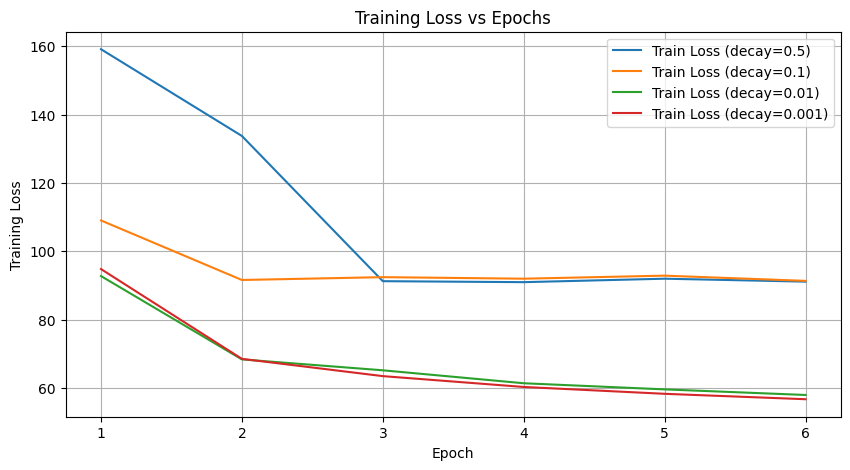

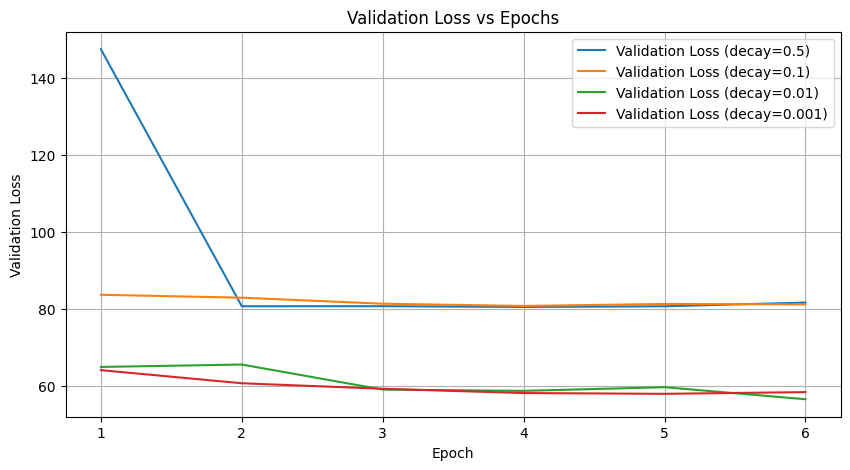

In [139]:
epochs = 6
decay_vals = [0.5,1e-1,1e-2, 1e-3]

all_losses = []

# Train once per decay value and store losses
for decay in decay_vals:
    model = FullMultimodalModel(tab_input_dim=train_df.drop(["id", target_clm], axis=1).shape[1])
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=decay)
    losses = run_training(model, optimizer, criterion, device, epochs, train_loader, val_loader)
    
    all_losses.append((decay, losses))  # Store both training and validation losses

# Plot training loss
plt.figure(figsize=(10, 5))
for decay, losses in all_losses:
    plt.plot(range(1, len(losses[0]) + 1), losses[0], label=f"Train Loss (decay={decay})")
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 5))
for decay, losses in all_losses:
    plt.plot(range(1, len(losses[1]) + 1), losses[1], label=f"Validation Loss (decay={decay})")
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()




In [123]:
epochs = 13
model = FullMultimodalModel(tab_input_dim=train_df.drop(["id", target_clm], axis=1).shape[1])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

criterion = nn.HuberLoss(delta=1.0)
losses = run_training(model, optimizer, criterion, device, epochs, train_loader, val_loader)

Epoch 13 (Validate): 100%|██████████| 13/13 [07:11<00:00, 33.16s/it, loss=45.245] 


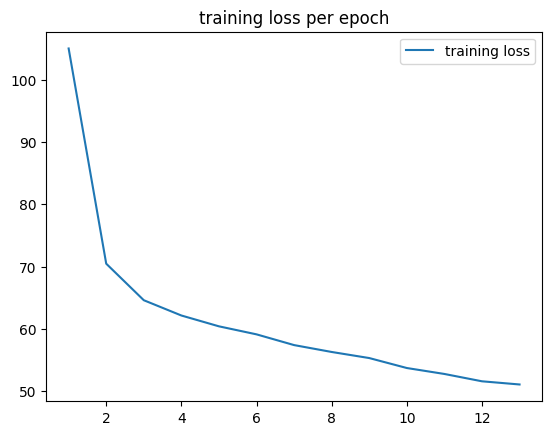

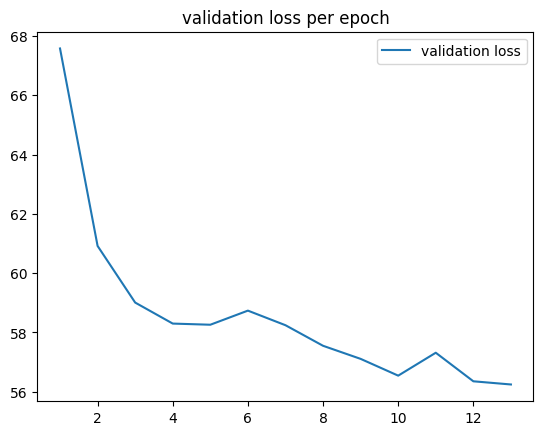

In [124]:
plotLosses(losses[0], title="training")
plotLosses(losses[1], title="validation")

In [134]:
#evaluate
abs_err, raw_err = evaluate_model(model, test_loader, device)


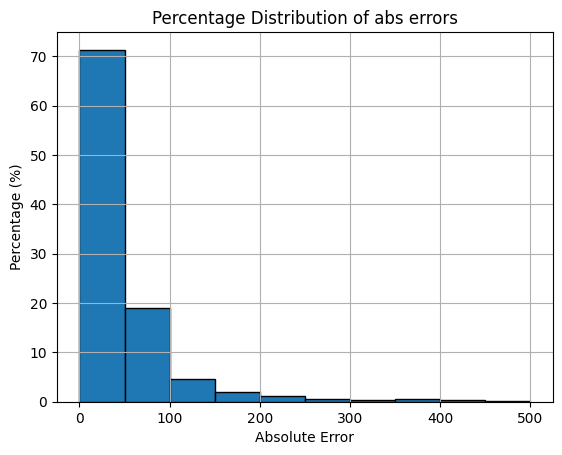

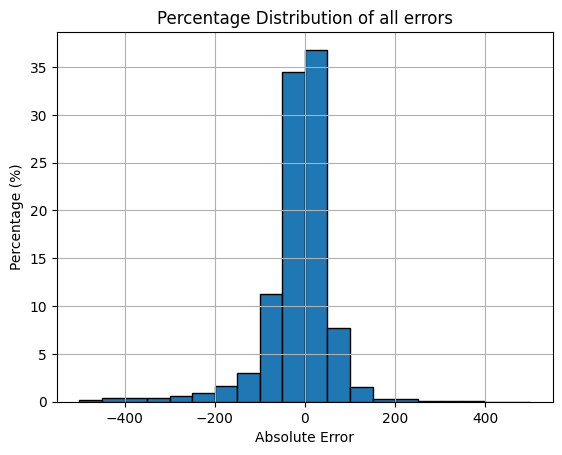

In [137]:
plot_accuracy(abs_err, bins = 10, min_range = 0, max_range = 500, title="abs errors")
plot_accuracy(raw_err, bins = 20, min_range = -500, max_range = 500, title="all errors")

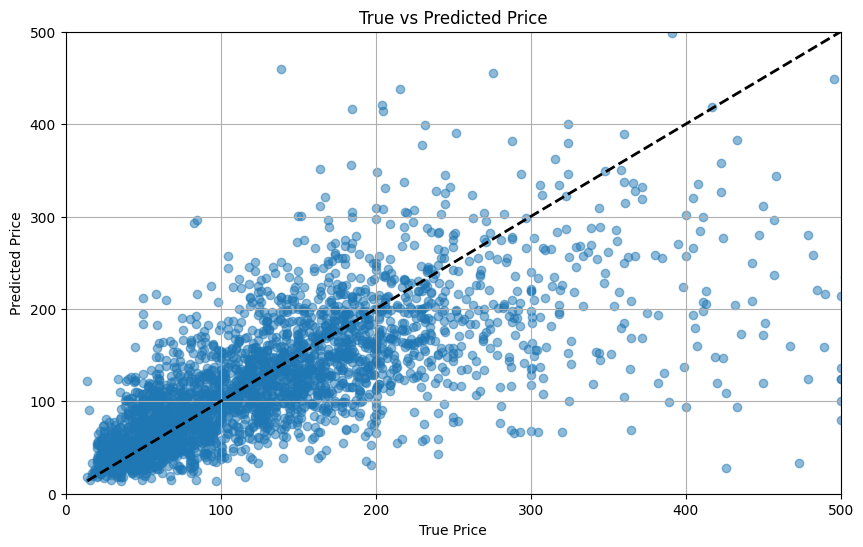

In [136]:
plot_true_vs_predicted(model, test_loader, device)


In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import pandas as pd

# 1. Create smaller representative sample (20% of data for speed)
sample_df = train_df.sample(frac=0.8, random_state=42)  # Adjust fraction as needed

# 2. Split into features and target
X = sample_df.drop(['price'], axis=1)
y = sample_df['price']

# 3. Reduce feature dimensionality (if >100 features)
#if len(X.columns) > 100:
#    print(f"Original features: {len(X.columns)}")
#    selector = VarianceThreshold(threshold=0.01)  # Removes near-constant features
#    X = pd.DataFrame(selector.fit_transform(X), 
#                    columns=selector.get_feature_names_out())
#    print(f"Reduced features: {len(X.columns)}")

# 4. Create train/validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# 5. Train optimized Random Forest
rf = RandomForestRegressor(
    n_estimators=50,        # Fewer trees for speed
    max_depth=10,           # Shallower trees
    max_features='sqrt',    # Better for high-dimensional data
    min_samples_leaf=5,     # Prevent overfitting
    n_jobs=-1,             # Use all CPU cores
    random_state=42
).fit(X_train, y_train)

# 6. Evaluate
train_score = rf.score(X_train, y_train)
val_score = rf.score(X_val, y_val)
print(f"Training R2: {train_score:.3f}")
print(f"Validation R2: {val_score:.3f}")

# 7. Feature importance (diagnostics)
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 30 features:")
print(importances.head(30))

Training R2: 0.305
Validation R2: 0.100

Top 30 features:
                                     feature  importance
848           host_name_word_freq_apartments    0.031391
3                             minimum_nights    0.030414
853             host_name_word_freq_acomodis    0.028597
272                room_type_entire_home/apt    0.020204
0                                         id    0.019071
7                           availability_365    0.018834
466                      name_word_freq_flat    0.018545
41               review_scores_communication    0.017613
857            host_name_word_freq_apartment    0.015644
33                          availability_eoy    0.015285
273                   room_type_private_room    0.015118
6             calculated_host_listings_count    0.013464
5                          reviews_per_month    0.012965
404           property_type_entire_townhouse    0.012147
42                    review_scores_location    0.010012
207                    neighbo